## Import

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#구글 드라이브 경로 설정 
DATA_PATH = '/content/gdrive/My Drive/LG Aimers phase2/' 
MODEL_PATH='/content/gdrive/My Drive/LG Aimers phase2/'
SUBMISSION_PATH='/content/gdrive/My Drive/LG Aimers phase2/' 

In [ ]:
import pandas as pd
import random
import os
import numpy as np
import sklearn.metrics as metrics
import statistics
import math as math
import seaborn as sns

from sklearn.ensemble import VotingClassifier
from lightgbm import plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data Load

In [ ]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

#EDA

In [ ]:
# 칼럼 드랍
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [ ]:
# train 데이터 확인 (rows 598, columns 2877, 많은 결측치 존재)
print(train_x)

        LINE PRODUCT_CODE   X_1   X_2  X_3   X_4   X_5  X_6   X_7   X_8  ...  \
0    T050304         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
1    T050307         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
2    T050304         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
3    T050307         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
4    T050304         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
..       ...          ...   ...   ...  ...   ...   ...  ...   ...   ...  ...   
593  T100306         T_31   2.0  95.0  0.0  45.0  10.0  0.0  50.0  10.0  ...   
594  T050304         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
595  T050304         A_31   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
596  T100304         O_31  40.0  94.0  0.0  45.0  11.0  0.0  45.0  10.0  ...   
597  T100306         O_31  21.0  87.0  0.0  45.0  10.0  0.0  61.0  10.0  ...   

     X_2866  X_2867  X_2868  X_2869  X_

<Axes: xlabel='Y_Class', ylabel='count'>

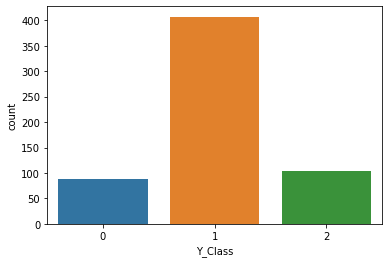

In [ ]:
# Y_Class 분포 확인, class_imbalance => over_sampling 시도해보았으나 성능향상 x
sns.countplot(data=train_df, x='Y_Class')

#Data preprocessing

In [ ]:
# 레이블인코딩
qual_col = ['LINE','PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])
print('Done.')

Done.


In [ ]:
# 결측치 처리
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [ ]:
# 결측치 확인
print(train_x.isna().any())
print(test_x.isna().any())

LINE            False
PRODUCT_CODE    False
X_1             False
X_2             False
X_3             False
                ...  
X_2871          False
X_2872          False
X_2873          False
X_2874          False
X_2875          False
Length: 2877, dtype: bool
LINE            False
PRODUCT_CODE    False
X_1             False
X_2             False
X_3             False
                ...  
X_2871          False
X_2872          False
X_2873          False
X_2874          False
X_2875          False
Length: 2877, dtype: bool


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

# train-test분리
X_train, X_test, y_train, y_test = train_test_split(train_x ,train_y, test_size=0.2)

# train-validation분리
X2_train, X_val, y2_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# XGBClassifier, GradientBoostingClassifier HyperParameter Tuning & Test

In [ ]:
XGB = XGBClassifier(n_estimators=100, learning_rate=0.08, gamma = 0, subsample=0.75, colsample_bytree = 1, max_depth=7)
GB = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 200, random_state= 37)

XGB.fit(X_train, y_train)
preds = XGB.predict(X_test)

print("훈련 세트 정확도: {:.3f}".format(XGB.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(XGB.score(X_test, y_test)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds, y_test, average = "macro")))
print("\n")  

XGB.fit(X2_train, y2_train)
preds2 = XGB.predict(X_val)

print("검증훈련 세트 정확도: {:.3f}".format(XGB.score(X2_train, y2_train)))
print("검증테스트 세트 정확도: {:.3f}".format(XGB.score(X_val, y_val)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds2, y_val, average = "macro")))
print("\n") 

GB.fit(X_train, y_train)
preds = GB.predict(X_test) 

print("훈련 세트 정확도: {:.3f}".format(GB.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(GB.score(X_test, y_test)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds, y_test, average = "macro")))
print("\n") 

GB.fit(X2_train, y2_train)
preds2 = GB.predict(X_val)

print("검증훈련 세트 정확도: {:.3f}".format(GB.score(X2_train, y2_train)))
print("검증테스트 세트 정확도: {:.3f}".format(GB.score(X_val, y_val)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds2, y_val, average = "macro"))) 

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.758
현재 Macro F1 Score의 검증 점수: 0.502


검증훈련 세트 정확도: 1.000
검증테스트 세트 정확도: 0.729
현재 Macro F1 Score의 검증 점수: 0.615


훈련 세트 정확도: 0.996
테스트 세트 정확도: 0.808
현재 Macro F1 Score의 검증 점수: 0.619


검증훈련 세트 정확도: 1.000
검증테스트 세트 정확도: 0.781
현재 Macro F1 Score의 검증 점수: 0.710


#Voting Classifier Model

In [ ]:
VM = VotingClassifier(
    estimators=[('XGB',XGB),('GB',GB)], 
    voting='soft'
    )

In [ ]:
VM.fit(train_x, train_y)
preds = VM.predict(test_x)

## Submit

In [ ]:
submit = pd.read_csv(DATA_PATH + './sample_submission.csv')

In [ ]:
submit['Y_Class'] = preds

In [ ]:
submit.to_csv(DATA_PATH + './code.csv', index=False)